This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

* This notebook is to present how our logistic regression model works on the cerner sample data for predicting readmission using pytorch library.
* The logistic regression model has the architecture of an embedding layer, a linear activation and sigmoid transformation.
* Our model currently achieves around 0.81 test accuracy.
* Visualization of training loss, training auc, validation auc, and test auc for each epoch as well as how average loss, training auc, validation auc and test auc change with epochs are shown at the end.

In [1]:
from __future__ import print_function, division
from io import open
import string
import re
import random
import pandas as pd
import os
import sys
import argparse
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torchviz import make_dot, make_dot_from_trace

from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

try:
    import cPickle as pickle
except:
    import pickle

In [2]:
# import self-defined modules
# import ehr_pytorch.model as model 
# import ehr.pytorch.Loaddata as Loaddata
# import ehr.pytorch.TrainVeTe as TVT 

import model_em as model #here the em experiment
import Loaddata as Loaddata
import TrainVaTe_em as TVT

# check GPU availability
use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
parser = argparse.ArgumentParser(description='30 Hospital Readmission Model with Pytorch: LR, RNN, CNN')
# learning
parser.add_argument('-lr', type=float, default=np.exp(-7.8810), help='initial learning rate [default: 0.0004]')
parser.add_argument('-L2', type=float, default=np.exp(-5.8401), help='L2 regularization [default: 0.003]')
parser.add_argument('-epochs', type=int, default=20, help='number of epochs for train [default: 20]')
parser.add_argument('-batch_size', type=int, default=1, help='batch size for training [default: 1]')
#parser.add_argument('-save-dir', type=str, default='snapshot', help='where to save the snapshot')
#parser.add_argument('-save-best', type=bool, default=True, help='whether to save when get best performance')
# data 
parser.add_argument('-seq_file', type = str, default = 'data/cerner/hospital_data/h143.visits' , help='the path to the Pickled file containing visit information of patients')
parser.add_argument('-label_file', type = str, default = 'data/cerner/hospital_data/h143.labels', help='the path to the Pickled file containing label information of patients')
parser.add_argument('-validation_ratio', type = float, default = 0.1, help='validation data size [default: 0.1]')
parser.add_argument('-test_ratio', type = float, default = 0.2, help='test data size [default: 0.2]')
# model
parser.add_argument('-which_model', type = str, default = 'LR', help='choose from {"LR", "RNN", "CNN"}')
parser.add_argument('-input_size', type = int, default =20000, help='input dimension [default: 20000]')
parser.add_argument('-embed_dim', type=int, default=128, help='number of embedding dimension [default: 128]')
parser.add_argument('-ch_out', type=int, default=64, help='number of each kind of kernel [default; 64]')
parser.add_argument('-kernel_sizes', type=list, default=[3], help='comma-separated kernel size to use for convolution [default:[3]')
parser.add_argument('-dropout', type=float, default=0.1, help='the probability for dropout [default: 0.1]')
parser.add_argument('-eb_mode', type=str, default='sum', help= "embedding mode [default: 'sum']")

_StoreAction(option_strings=['-eb_mode'], dest='eb_mode', nargs=None, const=None, default='sum', type=<class 'str'>, choices=None, help="embedding mode [default: 'sum']", metavar=None)

In [4]:
# a block to simulate args reading from command line 
args = parser.parse_args(args=[])
args.lr = np.exp(-7.8810)
args.L2 = np.exp(-5.8401)
args.epochs = 20
args.batch_size = 1
#args.seq_file = 'data/cerner/hospital_data/h143.visits'
#args.label_file = 'data/cerner/hospital_data/h143.labels'
args.seq_file = 'Data/h143.visits'
args.label_file = 'Data/h143.labels'
args.which_model = 'LR'
args.input_size = 20000

In [5]:
# load and prepare data
set_x = pickle.load(open(args.seq_file, 'rb'), encoding='bytes')
set_y = pickle.load(open(args.label_file, 'rb'),encoding='bytes')

#preprocessing
# LR needs to have input format of list; list of list for NN models
if args.which_model == 'LR':
    model_x = []
    for patient in set_x:
        model_x.append([each for visit in patient for each in visit])  
else: 
    model_x = set_x     
    
merged_set= [[set_y[i],model_x[i]] for i in range(len(set_y))] #list of list or list of lists of lists
print("\nLoading and preparing data...")    
train1, valid1, test1 = Loaddata.load_data(merged_set)
print("\nSample data after split:")  
print(train1[0])
print("model is", args.which_model)


Loading and preparing data...

Sample data after split:
[0, [1667, 144, 62, 85, 1667, 144, 62, 85]]
model is LR


Parameter containing:
 2.3050e-01 -1.6349e+00
 8.6529e-02  4.8474e-01
 1.5986e-01  1.2769e+00
           ⋮            
-1.6623e-01 -2.3827e-02
-9.4694e-02 -1.0309e+00
 6.5178e-01  4.9189e-02
[torch.FloatTensor of size 20000x2]

15815
      emb_0     emb_1                           types
0  0.230504 -1.634936                            Code
1  0.086529  0.484736  b'M_ACETAMINOPHEN-HYDROCODONE'
2  0.159861  1.276925         b'M_BACITRACIN TOPICAL'
3 -0.195739 -0.138754    b'M_BUPIVACAINE-EPINEPHRINE'
4  0.997644  0.138306                  b'M_CEFAZOLIN'


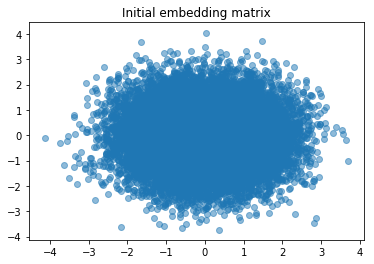

In [6]:
# model loading part
if args.which_model == 'LR': 
    ehr_model = model.EHR_LR(args.input_size)
elif args.which_model == 'RNN':
    ehr_model = model.EHR_RNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode) 
else: 
    ehr_model = model.EHR_CNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode, args.ch_out, args.kernel_sizes)    
if use_cuda:
    ehr_model = ehr_model.cuda()

optimizer = optim.Adam(ehr_model.parameters(), lr=args.lr, weight_decay=args.L2)

In [7]:
## train validation and test part
current_loss_allep=[]
all_losses_allep=[]
avg_losses_allep=[]
train_auc_allep =[]
valid_auc_allep =[]
test_auc_allep=[]

In [8]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


 Current running on: Epoch  0 Training loss:  Average loss 0.5356804989393823


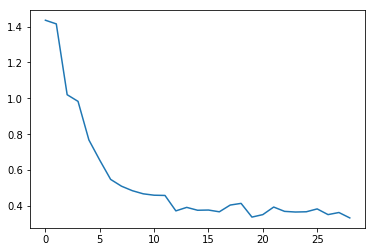

Epoch  0 Summary:  Training_auc : 0.6735727322150067  , Validation_auc :  0.6551554652866229  ,& Test_auc :  0.6621718236571152  Avg Loss:  0.5356804989393823 Train Time (0m 38s) Eval Time (0m 17s)


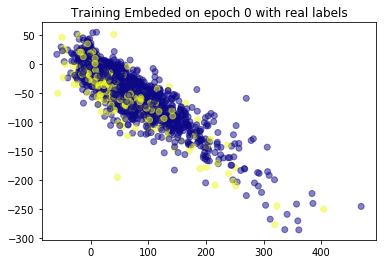

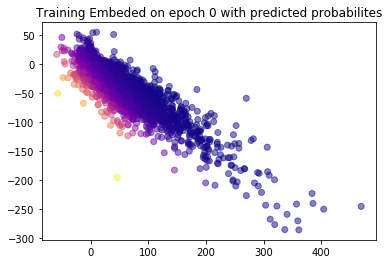


 Current running on: Epoch  1 Training loss:  Average loss 0.3465504941283314


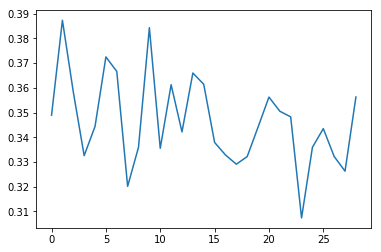

Epoch  1 Summary:  Training_auc : 0.7677845131154781  , Validation_auc :  0.7624183986881498  ,& Test_auc :  0.7841528977256195  Avg Loss:  0.3465504941283314 Train Time (0m 37s) Eval Time (0m 21s)


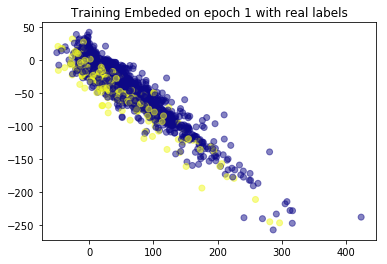

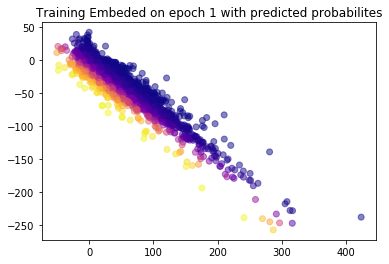


 Current running on: Epoch  2 Training loss:  Average loss 0.33579319510003125


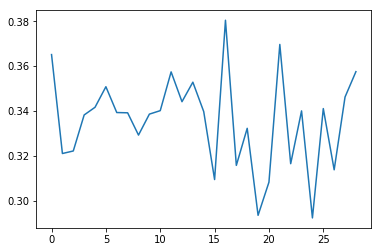

Epoch  2 Summary:  Training_auc : 0.7726037530850836  , Validation_auc :  0.7576541443111721  ,& Test_auc :  0.7797875924928283  Avg Loss:  0.33579319510003125 Train Time (0m 35s) Eval Time (0m 17s)


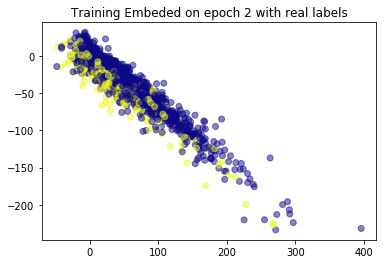

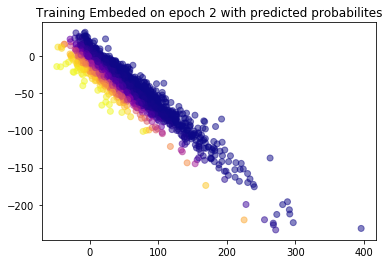


 Current running on: Epoch  3 Training loss:  Average loss 0.3315912816155018


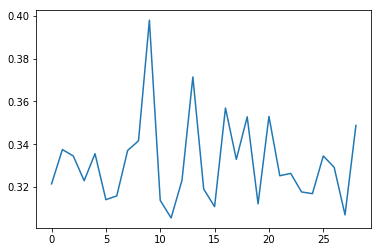

Epoch  3 Summary:  Training_auc : 0.7853372075028413  , Validation_auc :  0.7657349076847166  ,& Test_auc :  0.7946690491102277  Avg Loss:  0.3315912816155018 Train Time (0m 32s) Eval Time (0m 17s)


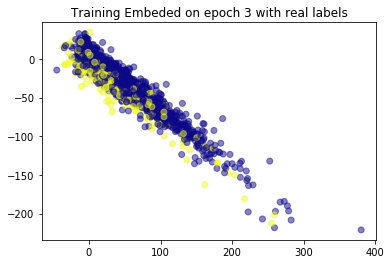

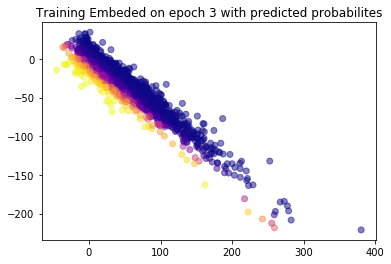


 Current running on: Epoch  4 Training loss:  Average loss 0.3296187780763899


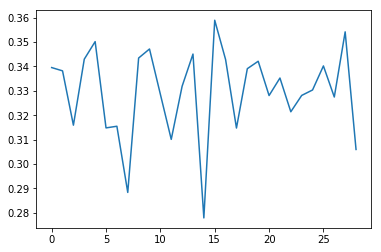

Epoch  4 Summary:  Training_auc : 0.7727305803840843  , Validation_auc :  0.7453361506857326  ,& Test_auc :  0.7695873764031483  Avg Loss:  0.3296187780763899 Train Time (0m 30s) Eval Time (0m 17s)


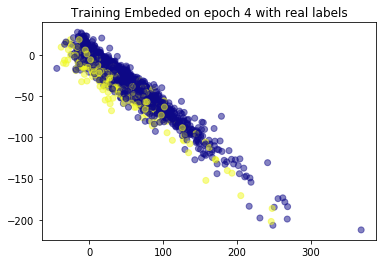

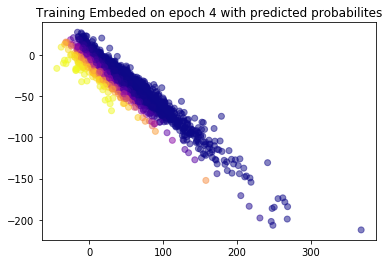


 Current running on: Epoch  5 Training loss:  Average loss 0.32871737763290043


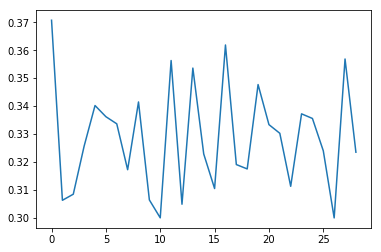

Epoch  5 Summary:  Training_auc : 0.7740818595552701  , Validation_auc :  0.7550993477359274  ,& Test_auc :  0.7821568012635781  Avg Loss:  0.32871737763290043 Train Time (0m 32s) Eval Time (0m 17s)


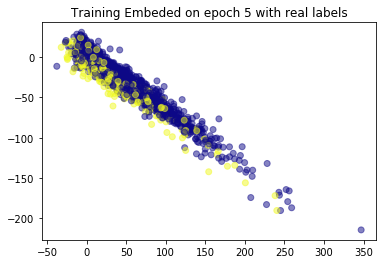

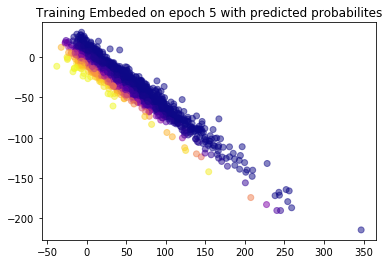


 Current running on: Epoch  6 Training loss:  Average loss 0.3267753256788066


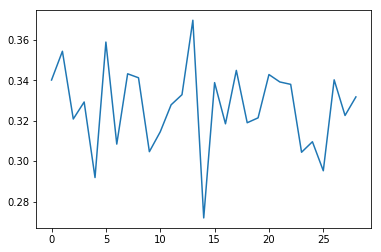

Epoch  6 Summary:  Training_auc : 0.7852605498887689  , Validation_auc :  0.762235347281304  ,& Test_auc :  0.7921106326945916  Avg Loss:  0.3267753256788066 Train Time (0m 36s) Eval Time (0m 17s)


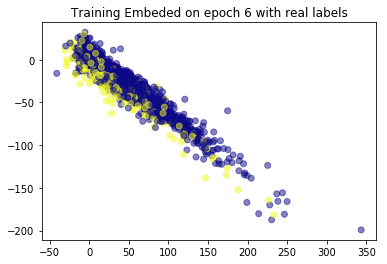

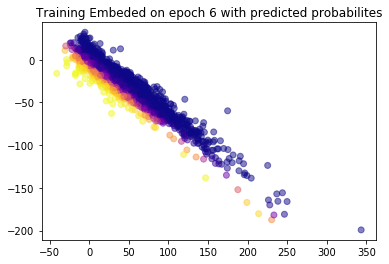


 Current running on: Epoch  7 Training loss:  Average loss 0.3269046729723233


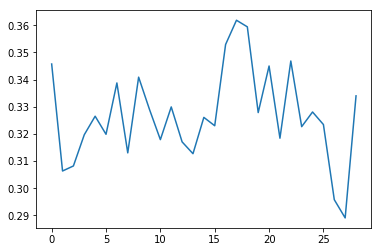

Epoch  7 Summary:  Training_auc : 0.7818708258438025  , Validation_auc :  0.7648445128564926  ,& Test_auc :  0.7886587999435436  Avg Loss:  0.3269046729723233 Train Time (0m 36s) Eval Time (0m 17s)


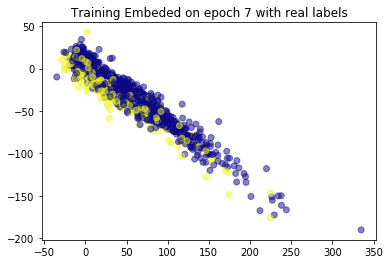

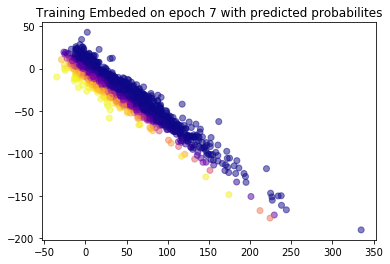


 Current running on: Epoch  8 Training loss:  Average loss 0.3253762709038997


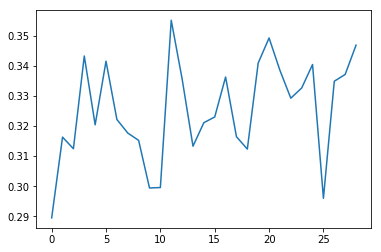

Epoch  8 Summary:  Training_auc : 0.7948460166251795  , Validation_auc :  0.7694740741833584  ,& Test_auc :  0.8028714690644481  Avg Loss:  0.3253762709038997 Train Time (0m 45s) Eval Time (0m 17s)


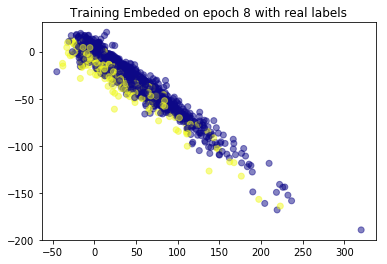

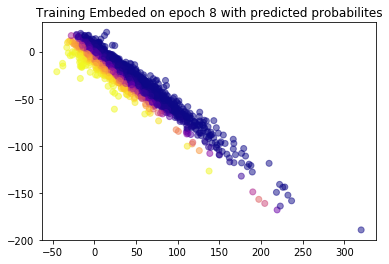


 Current running on: Epoch  9 Training loss:  Average loss 0.32642902362614973


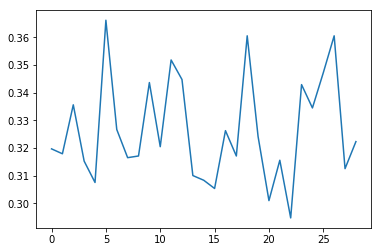

Epoch  9 Summary:  Training_auc : 0.800205765062301  , Validation_auc :  0.7823302935871355  ,& Test_auc :  0.8079037941333801  Avg Loss:  0.32642902362614973 Train Time (0m 31s) Eval Time (0m 17s)


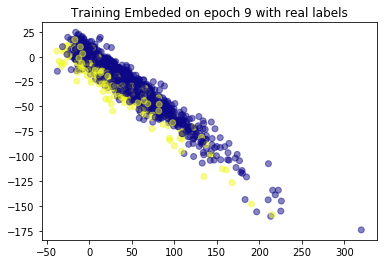

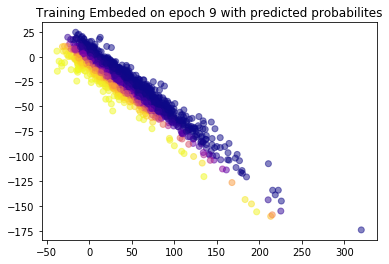


 Current running on: Epoch  10 Training loss:  Average loss 0.324982474843217


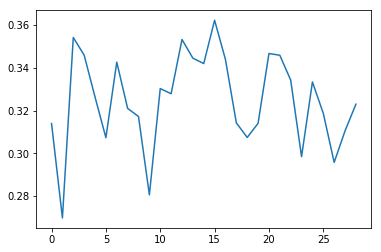

Epoch  10 Summary:  Training_auc : 0.7872080822146056  , Validation_auc :  0.7604086581676173  ,& Test_auc :  0.7892207799624549  Avg Loss:  0.324982474843217 Train Time (0m 34s) Eval Time (0m 18s)


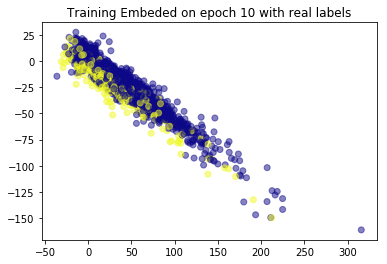

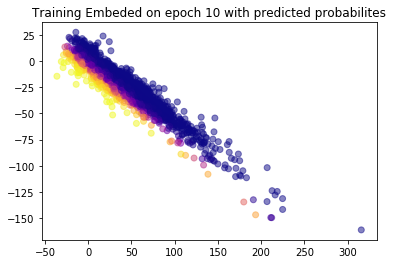


 Current running on: Epoch  11 Training loss:  Average loss 0.3268333235798276


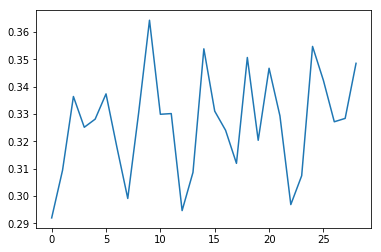

Epoch  11 Summary:  Training_auc : 0.7952904269924599  , Validation_auc :  0.7779586434961835  ,& Test_auc :  0.8037157988315493  Avg Loss:  0.3268333235798276 Train Time (0m 37s) Eval Time (0m 17s)


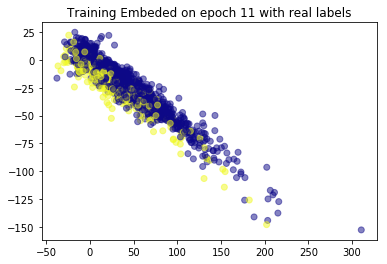

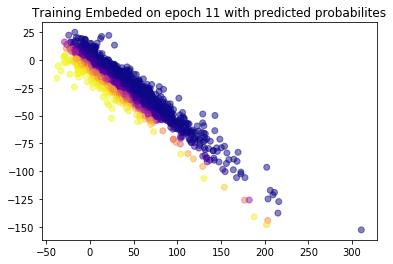


 Current running on: Epoch  12 Training loss:  Average loss 0.32618928814083203


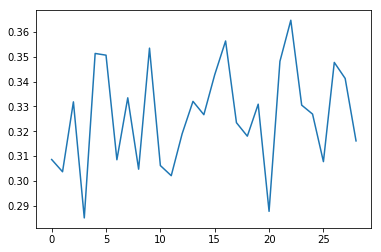

Epoch  12 Summary:  Training_auc : 0.7975054633954638  , Validation_auc :  0.777893072842985  ,& Test_auc :  0.8078409062169157  Avg Loss:  0.32618928814083203 Train Time (0m 36s) Eval Time (0m 17s)


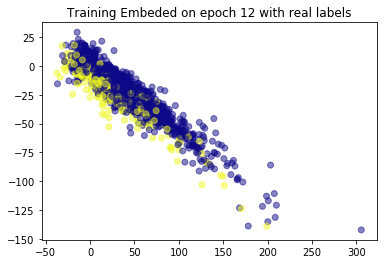

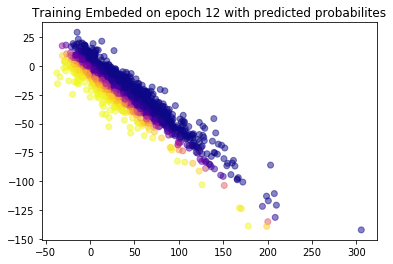


 Current running on: Epoch  13 Training loss:  Average loss 0.3260945659545864


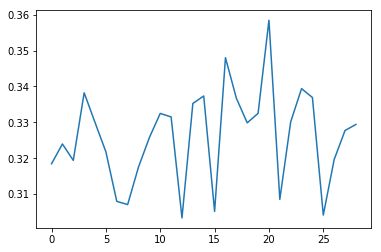

Epoch  13 Summary:  Training_auc : 0.7891911024970718  , Validation_auc :  0.7587117443050522  ,& Test_auc :  0.7947389396811739  Avg Loss:  0.3260945659545864 Train Time (0m 36s) Eval Time (0m 17s)


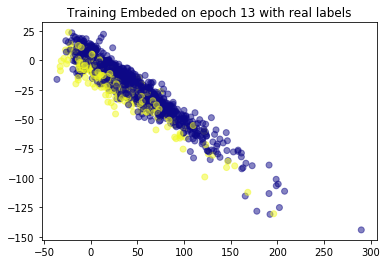

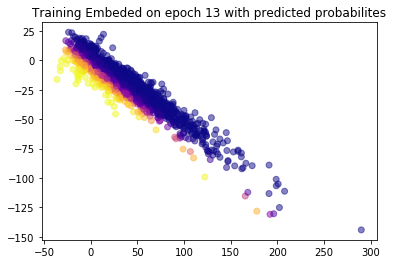


 Current running on: Epoch  14 Training loss:  Average loss 0.32522409498807464


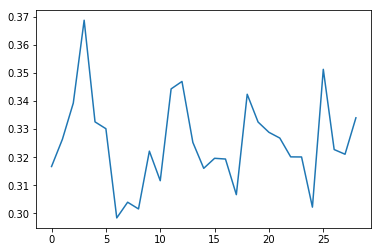

Epoch  14 Summary:  Training_auc : 0.7906559089859178  , Validation_auc :  0.765045322981913  ,& Test_auc :  0.8025819806879027  Avg Loss:  0.32522409498807464 Train Time (0m 37s) Eval Time (0m 17s)


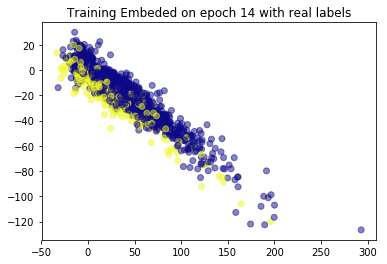

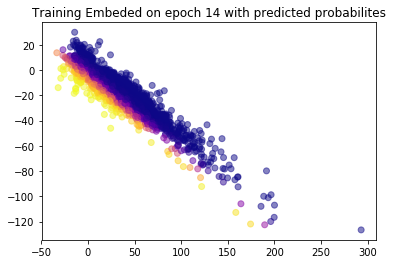


 Current running on: Epoch  15 Training loss:  Average loss 0.3250748637199395


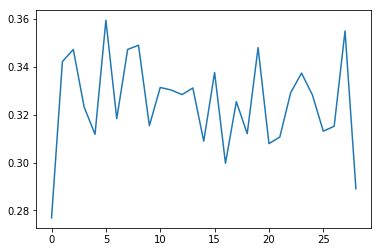

Epoch  15 Summary:  Training_auc : 0.789076721590557  , Validation_auc :  0.7631246492653082  ,& Test_auc :  0.7927708538370604  Avg Loss:  0.3250748637199395 Train Time (0m 36s) Eval Time (0m 17s)


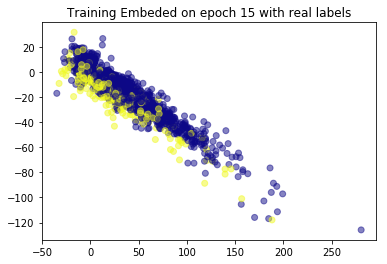

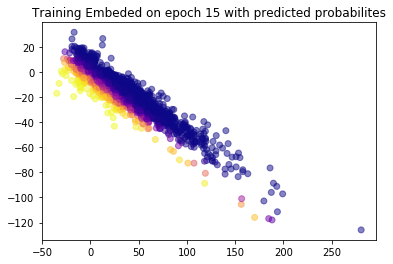


 Current running on: Epoch  16 Training loss:  Average loss 0.32537956025224873


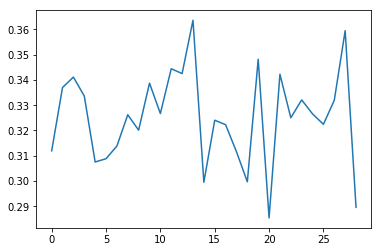

Epoch  16 Summary:  Training_auc : 0.7905343472631637  , Validation_auc :  0.7516235566942991  ,& Test_auc :  0.7982500570410398  Avg Loss:  0.32537956025224873 Train Time (0m 39s) Eval Time (0m 17s)


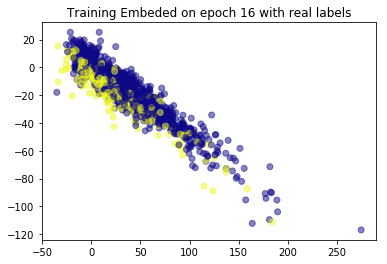

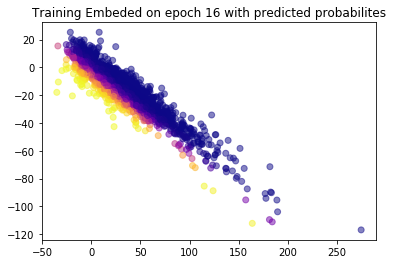


 Current running on: Epoch  17 Training loss:  Average loss 0.32574697889301535


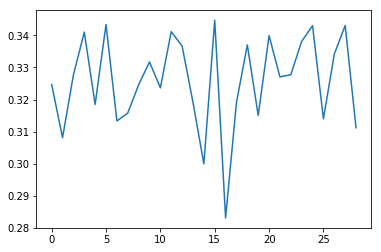

Epoch  17 Summary:  Training_auc : 0.7959898630348395  , Validation_auc :  0.766143631422987  ,& Test_auc :  0.7968422515424196  Avg Loss:  0.32574697889301535 Train Time (0m 37s) Eval Time (0m 17s)


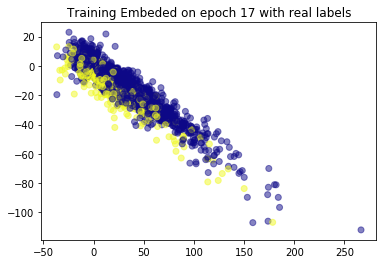

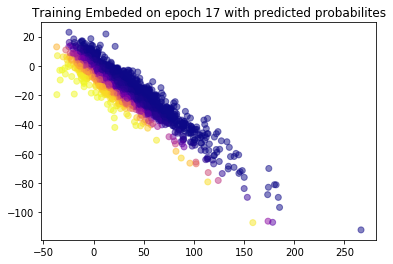


 Current running on: Epoch  18 Training loss:  Average loss 0.3260014020059142


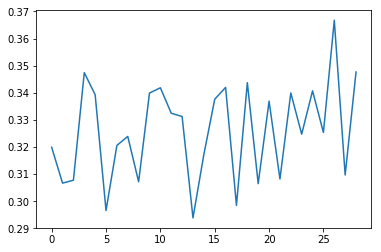

Epoch  18 Summary:  Training_auc : 0.7928786330235431  , Validation_auc :  0.7644625638016117  ,& Test_auc :  0.7962358080668948  Avg Loss:  0.3260014020059142 Train Time (0m 35s) Eval Time (0m 17s)


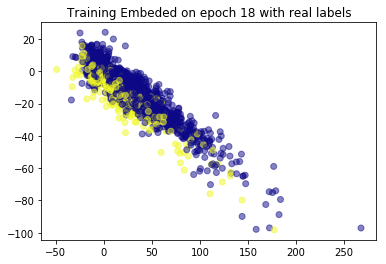

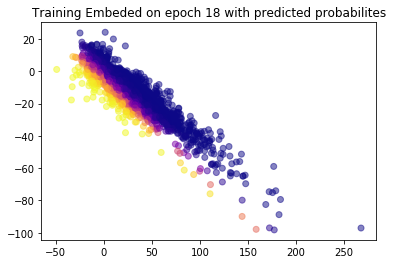


 Current running on: Epoch  19 Training loss:  Average loss 0.32604532140495257


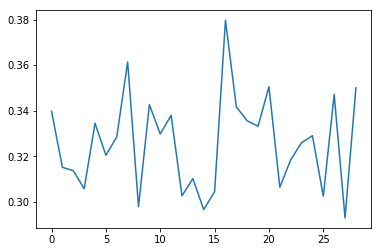

Epoch  19 Summary:  Training_auc : 0.7958487167828031  , Validation_auc :  0.7718133072362134  ,& Test_auc :  0.8048636222841599  Avg Loss:  0.32604532140495257 Train Time (0m 35s) Eval Time (0m 17s)


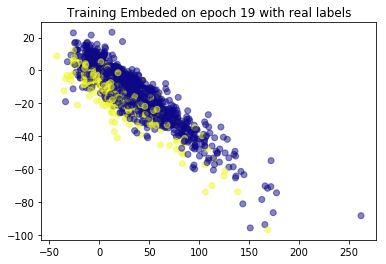

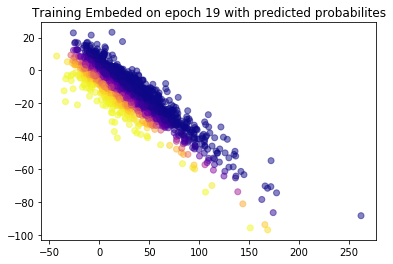

In [9]:
# train, validation, and test for each epoch 
for ep in range(args.epochs):
    start = time.time()
    current_loss, train_loss, em = TVT.train(train1, model= ehr_model, optimizer = optimizer, batch_size = args.batch_size) #mb=args.mb
    avg_loss = np.mean(train_loss)
    train_time = timeSince(start)
    print ('\n Current running on: Epoch ', ep,'Training loss:',' Average loss', avg_loss)
    #print(train_loss, '\n train loss plot')
    TVT.showPlot(train_loss)
    eval_start = time.time()
    train_auc, y_real, y_hat, emb = TVT.calculate_auc(model= ehr_model, data = train1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' Training auc:', train_auc)
    #TVT.auc_plot(y_real, y_hat)
    valid_auc, _, _, _  = TVT.calculate_auc(model = ehr_model, data = valid1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' validation auc:', valid_auc)
    #TVT.auc_plot(y_real, y_hat)
    test_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' test auc:', test_auc)
    #TVT.auc_plot(y_real, y_hat)
    eval_time = timeSince(eval_start)
    print ("Epoch ", ep, "Summary:  Training_auc :", train_auc, " , Validation_auc : ", valid_auc, " ,& Test_auc : " , test_auc, " Avg Loss: ", avg_loss, 'Train Time (%s) Eval Time (%s)'%(train_time,eval_time) )
    current_loss_allep.append(current_loss)
    all_losses_allep.append(train_loss)
    avg_losses_allep.append(avg_loss)
    train_auc_allep.append(train_auc)
    valid_auc_allep.append(valid_auc)
    test_auc_allep.append(test_auc)
    #print(emb)
    #print(len(emb)-1)
    #print(len(y_real))
    color1 = np.array([item for item in y_real])
    plt.figure()
    plt.scatter(emb[1:,0],emb[1:,1], c= color1, cmap= 'plasma', alpha = 0.5)
    plt.title('Training Embeded on epoch '+str(ep)+' with real labels')
    plt.show()
    color2 = np.array([item for item in y_hat])
    plt.scatter(emb[1:,0],emb[1:,1], c= color2, cmap='plasma', alpha = 0.5)
    plt.title('Training Embeded on epoch '+str(ep)+' with predicted probabilites')
    plt.show()

In [10]:
# average losses, training auc, validation auc and test auc with epochs
"""
TVT.showPlot(avg_losses_allep)
TVT.showPlot(train_auc_allep)
TVT.showPlot(valid_auc_allep)
TVT.showPlot(test_auc_allep)
"""

'\nTVT.showPlot(avg_losses_allep)\nTVT.showPlot(train_auc_allep)\nTVT.showPlot(valid_auc_allep)\nTVT.showPlot(test_auc_allep)\n'

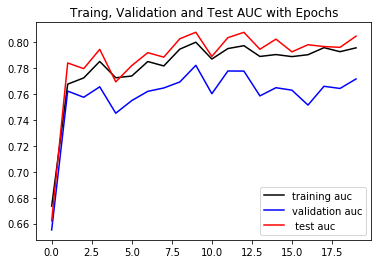

In [11]:
#plot all three auc in a same plot 
plt.plot(train_auc_allep, color= 'black', label = 'training auc')
plt.plot(valid_auc_allep, color ='blue', label = 'validation auc')
plt.plot(test_auc_allep, color = 'red', label =' test auc')
plt.title('Traing, Validation and Test AUC with Epochs' )
plt.legend(loc= 'lower right')
plt.show()

In [12]:
import plotly.plotly as py 
import plotly.graph_objs as go
py.sign_in('GinnyJZ','xJj3WJ9XiB3ijm4frOXc') #get my own sign in please

train_auc_fg= go.Scatter(x= np.arange(args.epochs), y=train_auc_allep, name ='Training auc')
valid_auc_fg= go.Scatter(x= np.arange(args.epochs), y=valid_auc_allep, name ='Validation auc')
test_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_auc_allep, name ='Test auc')

valid_max = max(valid_auc_allep)
test_max = max(test_auc_allep)

data = [train_auc_fg,valid_auc_fg, test_auc_fg]#,valid_auc_allep,test_auc_allep] 
layout = go.Layout(showlegend= True, xaxis=dict(dtick=1))
layout.update(dict(annotations=[go.Annotation(text="Max Valid", x=valid_auc_allep.index(valid_max), y=valid_max)]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='LR_Auc')
#url = py.plot(data, filename='some-data')  # gen. online plot
#py.image.save_as(data, 'some-data.png')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~GinnyJZ/0 or inside your plot.ly account where it is named 'LR_Auc'


In [13]:
#this block is to explore the embedding matrix vs. types. labels
emb_types = pickle.load(open('Data/h143.types', 'rb'),encoding='bytes')
print(type(emb_types)) #dictionary 
print(len(emb_types)) # it is 20000

<class 'dict'>
15815
